In [1]:
import matplotlib.pyplot as plt
from torch.optim import LBFGS, Adam
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

Text(0.5, 1.0, 'Slice of u(x,v) at t=0')

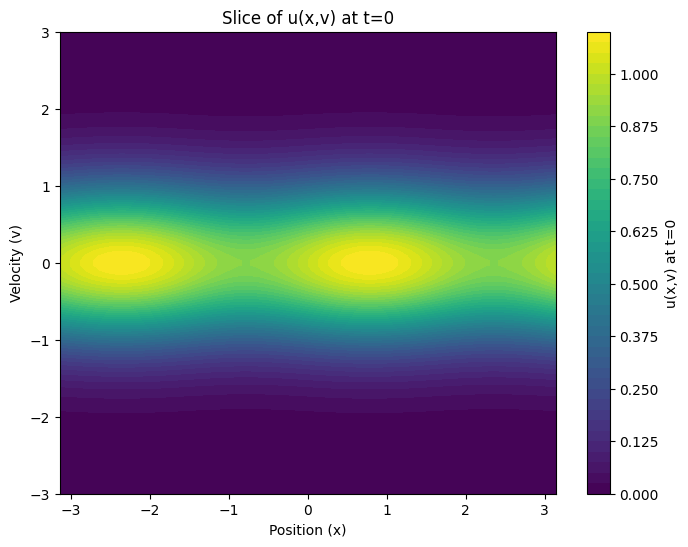

In [2]:
alpha = 0.1
t = np.linspace(0, 2*np.pi, 100)
x = np.linspace(-np.pi, np.pi, 100)
v = np.linspace(-3, 3, 100)

T, X, V = np.meshgrid(t, x, v, indexing='ij')

# Get slice when t = 0
u_slice_t0 = np.exp(-V[0, :, :]**2) * (1 + alpha * np.sin(2*X[0, :, :]))

plt.figure(figsize=(8, 6))
plt.contourf(x, v, u_slice_t0.T, levels=50, cmap='viridis')
plt.colorbar(label='u(x,v) at t=0')
plt.xlabel('Position (x)')
plt.ylabel('Velocity (v)')
plt.title('Slice of u(x,v) at t=0')

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

def u0(x, v):
    return torch.exp(-v**2) * (1 + alpha * torch.sin(2*x))

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        self.fourier_features = True
    
        
        self.net = nn.Sequential(
            nn.Linear(3, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, t, x, v):
        inputs = torch.cat([t, x, v], dim=1)
        return self.net(inputs)
    
model = PINN().to(device)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')


X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
V_tensor = torch.tensor(V, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)
T_tensor = torch.tensor(T, dtype=torch.float32, requires_grad=True).view(-1, 1).to(device)


loss_track = []

def closure():
    global loss_track
    model.train()
    pred_res = model(T_tensor, X_tensor, V_tensor)
    
    pred_init = model(torch.zeros_like(X_tensor), X_tensor, V_tensor)
    
    pred_left = model(T_tensor, -np.pi*torch.ones_like(X_tensor), V_tensor)
    pred_right = model(T_tensor, np.pi*torch.ones_like(X_tensor), V_tensor)
    
    # compute u_t, v * u_x for vlasov eqn
    
    u_t = torch.autograd.grad(pred_res, T_tensor, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
    u_x = torch.autograd.grad(pred_res, X_tensor, grad_outputs=torch.ones_like(pred_res), create_graph=True)[0]
    v_u_x = V_tensor * u_x
    
    loss_res = torch.mean((u_t + v_u_x)**2)
    loss_ic = torch.mean((pred_init - u0(X_tensor, V_tensor))**2)
    loss_bc = torch.mean((pred_left - pred_right)**2)
    loss = loss_res + loss_ic + loss_bc
    
    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    
    optim.zero_grad()
    loss.backward()
    return loss


progress_bar = tqdm(range(1000))

for i in progress_bar:
    optim.step(closure)
    last_loss = loss_track[-1]
    progress_bar.set_postfix({
        "res": f"{last_loss[0]:.6f}",
        "ic": f"{last_loss[1]:.6f}",
        "bc": f"{last_loss[2]:.6f}",
    })

  0%|          | 0/1000 [00:00<?, ?it/s]/home/rtenacity/Projects/pinn-vlasov/.pinns/lib/python3.12/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 1000/1000 [24:15<00:00,  1.46s/it, res=0.000017, ic=0.000002, bc=0.000001] 


Computing frames: 100%|██████████| 50/50 [00:00<00:00, 1846.05it/s]


Animation saved as 'vlasov_evolution.gif'


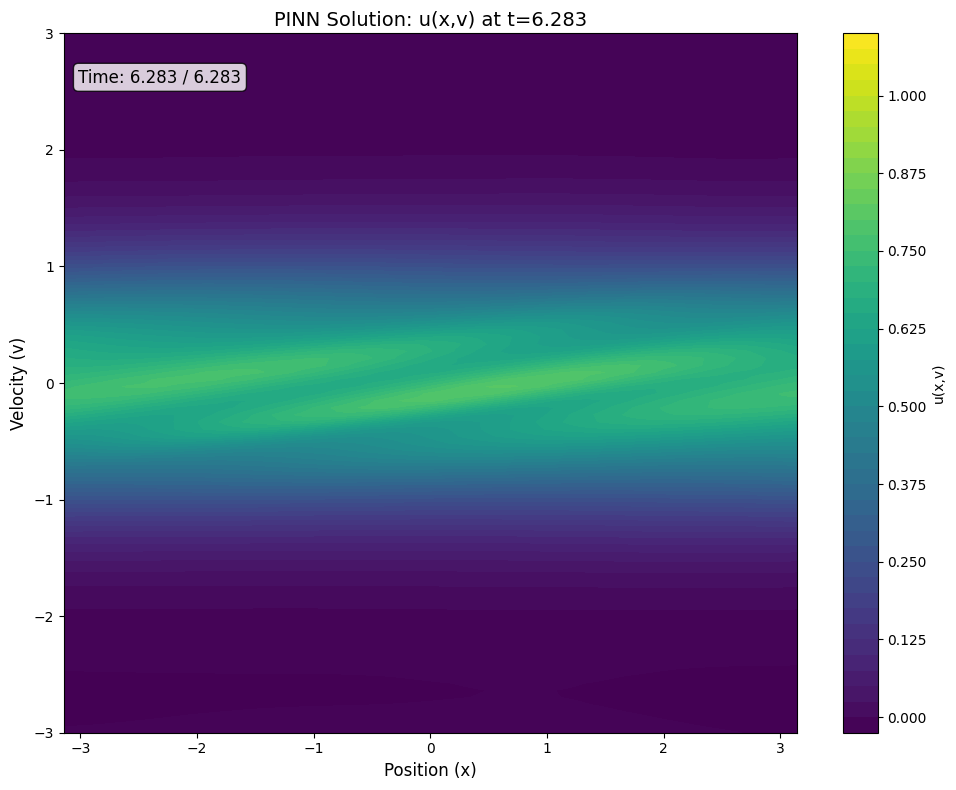

In [5]:
n_frames = 50
t_frames = np.linspace(0, 2*np.pi, n_frames)

x_anim = np.linspace(-np.pi, np.pi, 100)
v_anim = np.linspace(-3, 3, 100)
X_anim, V_anim = np.meshgrid(x_anim, v_anim)

u_animation = []
model.eval()
with torch.no_grad():
    for t_val in tqdm(t_frames, desc="Computing frames"):
        X_flat = torch.tensor(X_anim.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        V_flat = torch.tensor(V_anim.flatten(), dtype=torch.float32).view(-1, 1).to(device)
        T_flat = torch.full_like(X_flat, t_val).to(device)
        
        u_pred = model(T_flat, X_flat, V_flat).cpu().numpy().reshape(X_anim.shape)
        u_animation.append(u_pred)

fig, ax = plt.subplots(figsize=(10, 8))

# Initialize with first frame
contour = ax.contourf(x_anim, v_anim, u_animation[0], levels=50, cmap='viridis')
cbar = plt.colorbar(contour, ax=ax, label='u(x,v)')
ax.set_xlabel('Position (x)', fontsize=12)
ax.set_ylabel('Velocity (v)', fontsize=12)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, 
                    fontsize=14, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

def animate(frame):
    ax.clear()
    
    contour = ax.contourf(x_anim, v_anim, u_animation[frame], 
                          levels=50, cmap='viridis', vmin=0, vmax=1.5)
    
    ax.set_xlabel('Position (x)', fontsize=12)
    ax.set_ylabel('Velocity (v)', fontsize=12)
    ax.set_title(f'PINN Solution: u(x,v) at t={t_frames[frame]:.3f}', fontsize=14)
    
    time_text = ax.text(0.02, 0.95, f'Time: {t_frames[frame]:.3f} / {2*np.pi:.3f}', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    return contour,

anim = FuncAnimation(fig, animate, frames=n_frames, interval=100, blit=False, repeat=True)

anim.save('vlasov_evolution.gif', writer='pillow', fps=10, dpi=100)
print("Animation saved as 'vlasov_evolution.gif'")

plt.tight_layout()
plt.show()

In [6]:
torch.save(model.state_dict(), 'pinn_vlasov_model.pth')